In [42]:
import torch
import numpy as np
import cv2
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

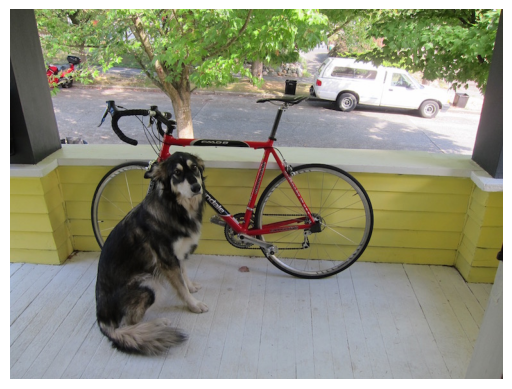

In [43]:
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    width, height = image.size
    return np.array(image), height, width

def show_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

image_path = 'images/dog.jpg'
image, h, w = load_image(image_path)
show_image(image)


In [44]:
def iou(bbox1, bbox2):
    x1 = max(bbox1[0], bbox2[0])
    y1 = max(bbox1[1], bbox2[1])
    x2 = min(bbox1[2], bbox2[2])
    y2 = min(bbox1[3], bbox2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area_bbox1 = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
    area_bbox2 = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])
    
    union = area_bbox1 + area_bbox2 - intersection
    return intersection / union if union > 0 else 0

In [45]:
def nms(boxes, scores, conf_threshold, iou_threshold):
    sorted_indices_desc = np.argsort(scores)[::-1]
    sorted_indices_desc = [idx for idx in sorted_indices_desc if scores[idx] >= conf_threshold]

    selected_indices = []

    while len(sorted_indices_desc) > 0:
        current = sorted_indices_desc[0]
        selected_indices.append(current)
        to_delete = []

        for i in range(1, len(sorted_indices_desc)):
            if iou(boxes[current], boxes[sorted_indices_desc[i]]) > iou_threshold:
                to_delete.append(i)
        to_delete.append(0)

        sorted_indices_desc = np.delete(sorted_indices_desc, to_delete)

    return selected_indices

In [46]:
def load_yolo_model(cfg_path, weights_path):
    net = cv2.dnn.readNet(weights_path, cfg_path)
    return net

In [47]:
def detect_objects(net, image):
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)

    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]

    np.set_printoptions(threshold=np.inf)
    detections = net.forward(output_layers)
    
    return detections

In [48]:
def apply_nms(detections, width, height, conf_threshold=0.5, iou_threshold=0.4):
    boxes = []
    confidences = []
    class_ids = []

    for output in detections:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > conf_threshold:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, x + w, y + h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indices = nms(boxes, confidences, conf_threshold, iou_threshold)
    return indices, boxes, confidences, class_ids

In [49]:
def draw_detections(image, indices, boxes, confidences, class_ids, class_names):
    for i in indices:
        box = boxes[i]
        x, y, x2, y2 = box
        label = str(class_names[class_ids[i]])
        confidence = confidences[i]
        color = (0, 255, 0)  

        cv2.rectangle(image, (x, y), (x2, y2), color, 2)
        cv2.putText(image, f"{label} {confidence:.2f}", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    show_image(image)

In [50]:
def load(image_path):
    class_names = open('cfg/coco.names').read().strip().split('\n')
    image, height, width = load_image(image_path)
    return class_names, image, height, width

In [51]:
def detect(image, height, width, cfg_path, weights_path, conf_threshold=0.5, iou_threshold=0.4):    
    net = load_yolo_model(cfg_path, weights_path)
    detections = detect_objects(net, image)
    indices, boxes, confidences, class_ids = apply_nms(detections, width, height, conf_threshold, iou_threshold)
    return indices, boxes, confidences, class_ids

In [52]:
def store_confidences(confidence_2d_array_map, indices, confidences, class_ids, class_names, i, j):   
    for idx in indices:        
        confidence_2d_array_map[i][j][class_names[class_ids[idx]]] = confidences[idx]

In [53]:
def test(image, height, width, cfg_path, weights_path, class_names, num_threholds):
    confidence_2d_array_map = [[{} for _ in range(num_threholds)] for _ in range(num_threholds)]
    for i in range(0,num_threholds):
        for j in range(0,num_threholds):
            indices, _, confidences, class_ids = detect(image, height, width, cfg_path, weights_path, 0.1 + i*0.1, 0.1 + j*0.1)
            store_confidences(confidence_2d_array_map, indices, confidences, class_ids, class_names, i, j)
    return confidence_2d_array_map

In [54]:
def plot_heatmap_for_class(class_name, confidence_2d_array_map, conf_thresholds, iou_thresholds):
    heatmap_data = np.zeros((len(iou_thresholds), len(conf_thresholds)))

    for i in range(len(conf_thresholds)):
        for j in range(len(iou_thresholds)):
            heatmap_data[i, j] = confidence_2d_array_map[i][j].get(class_name, 0)

    plt.figure()
    plt.imshow(heatmap_data, cmap='coolwarm', interpolation='nearest', vmin=0, vmax=1)
    plt.colorbar(label='Confidence')
    
    plt.xticks(range(len(conf_thresholds)), conf_thresholds)
    plt.yticks(range(len(iou_thresholds)), iou_thresholds)
    plt.xlabel('Confidence Threshold')
    plt.ylabel('IoU Threshold')
    plt.title(f'Heatmap for Class {class_name}')
    
    plt.show()

In [55]:
cfg_path = 'cfg/yolov3.cfg'
weights_path = 'cfg/yolov3.weights'

In [56]:
def draw_detection_and_generate_plots(img_path):
    class_names, image, height, width = load(img_path)
    indices, boxes, confidences, class_ids = detect(image, height, width, cfg_path, weights_path)
    draw_detections(image, indices, boxes, confidences, class_ids, class_names)

    num_thresholds = 9 
    confidence_map = test(image, height, width, cfg_path, weights_path, class_names, num_thresholds)
    
    conf_thresholds = ["{:.1f}".format(0.1 + i*0.1) for i in range(len(confidence_map))]
    iou_thresholds = conf_thresholds
    
    valid_class_ids = [class_ids[i] for i in indices]
    for i in valid_class_ids:
        plot_heatmap_for_class(class_names[i], confidence_map, conf_thresholds, iou_thresholds)

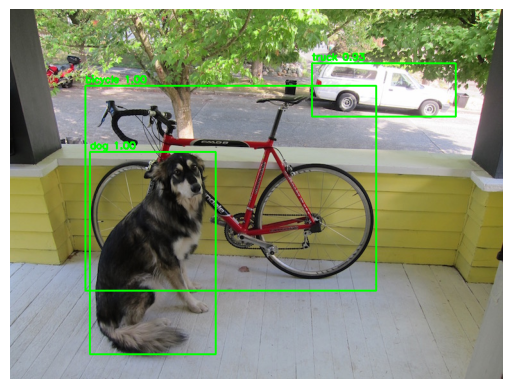

16, dog


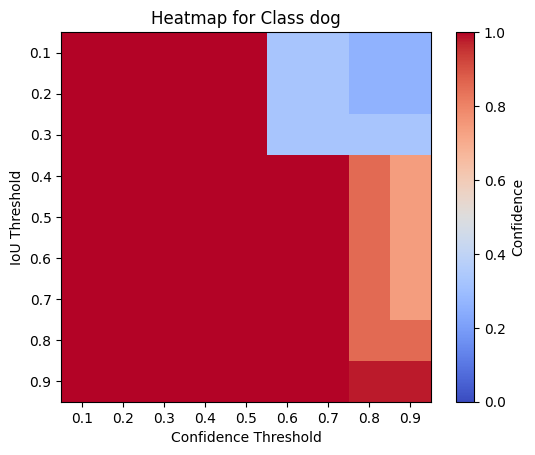

1, bicycle


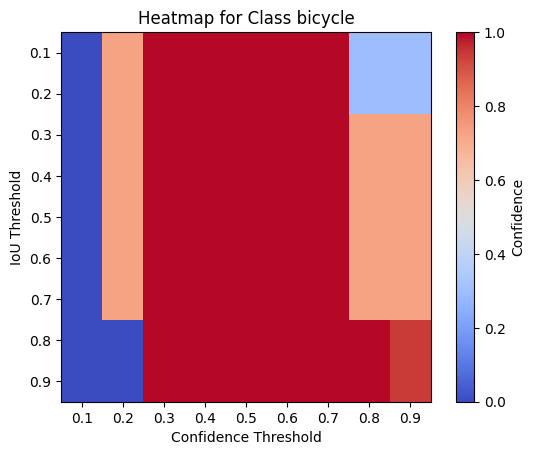

7, truck


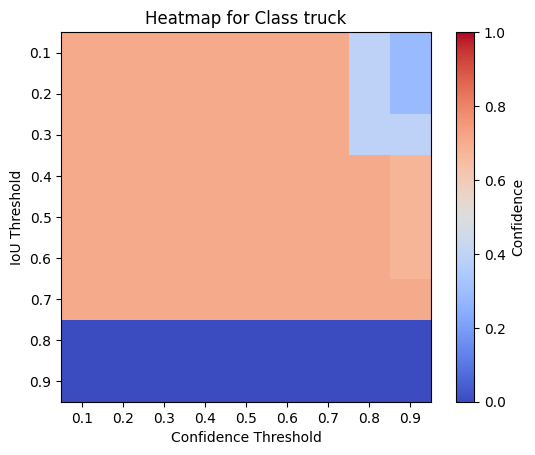

In [57]:
# dog.jpg
draw_detection_and_generate_plots('images/dog.jpg')

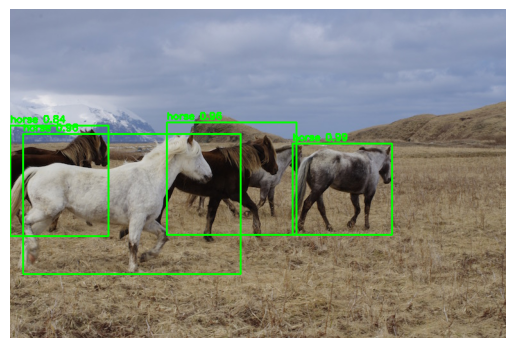

17, horse


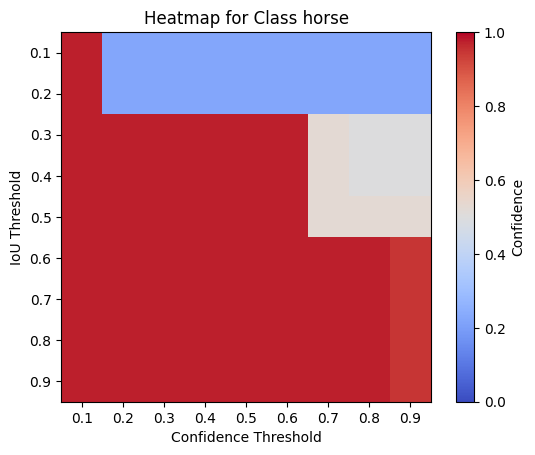

17, horse


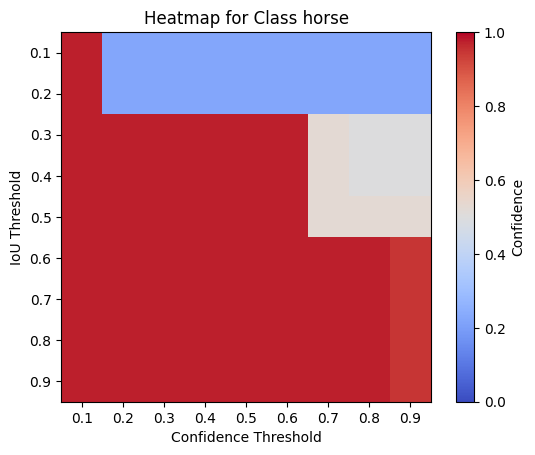

17, horse


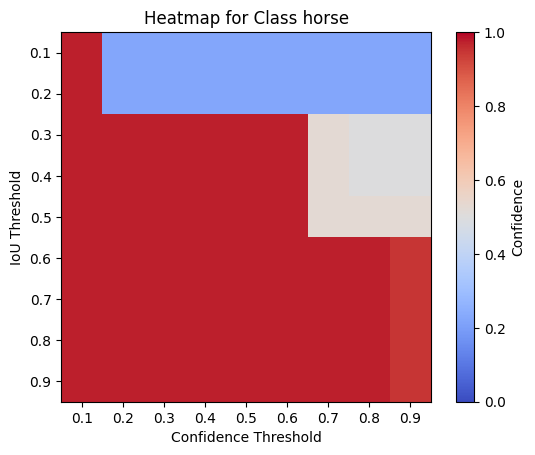

17, horse


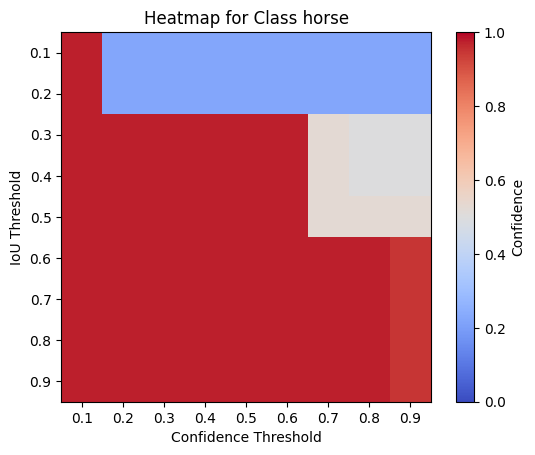

In [58]:
# horses.jpg
draw_detection_and_generate_plots('images/horses.jpg')

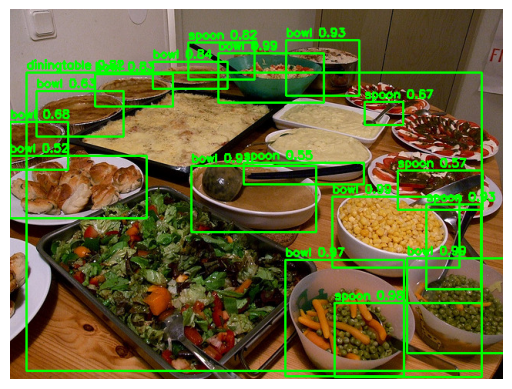

45, bowl


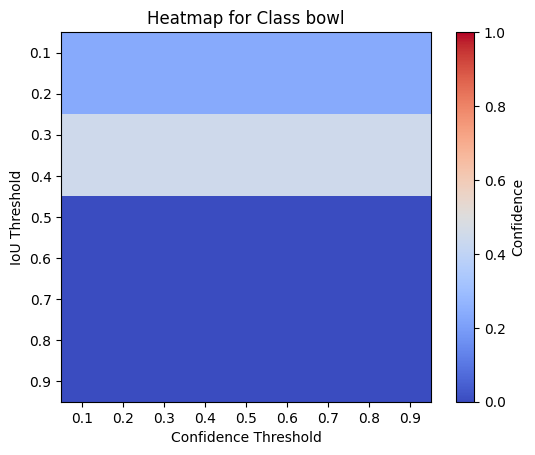

45, bowl


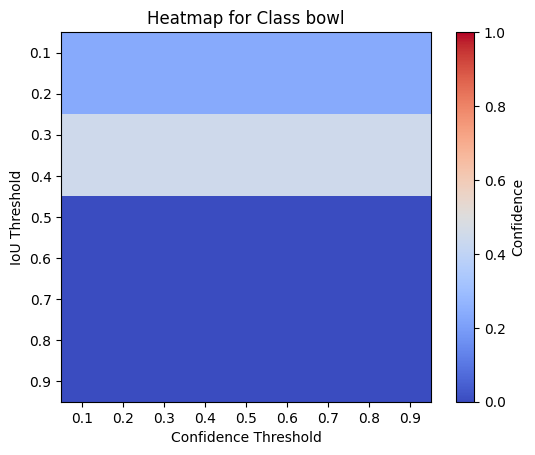

45, bowl


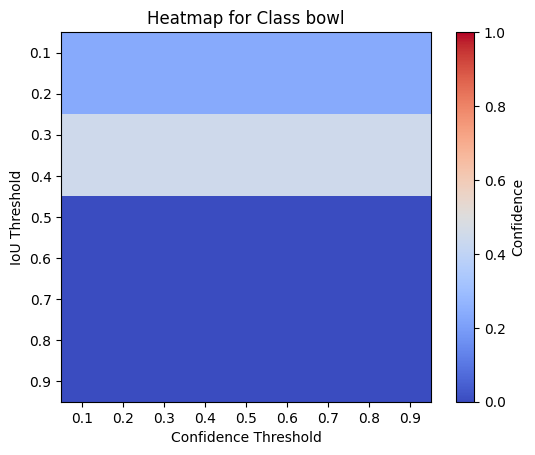

44, spoon


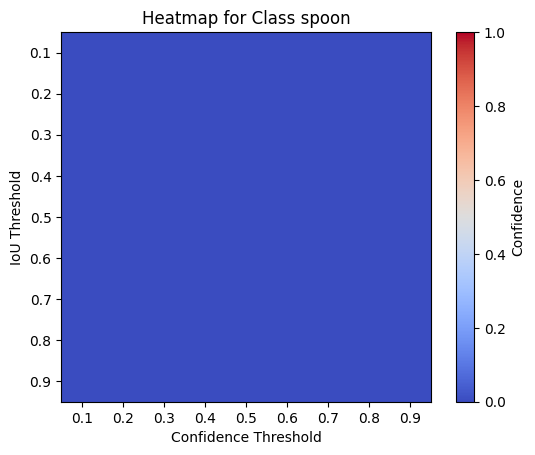

45, bowl


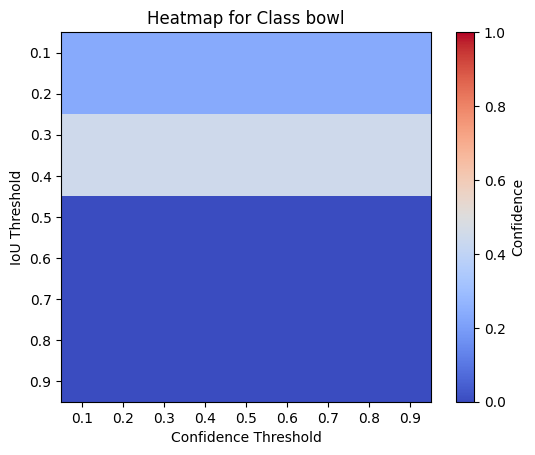

45, bowl


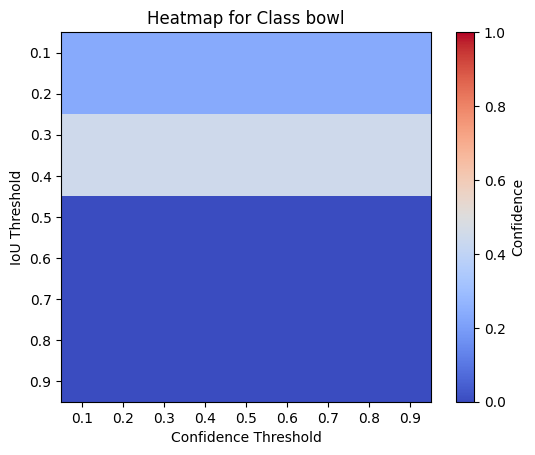

44, spoon


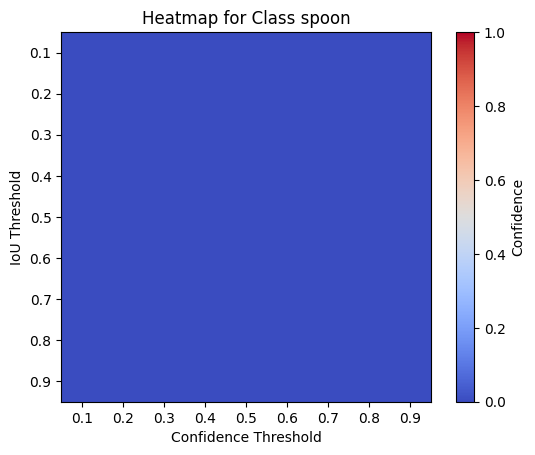

45, bowl


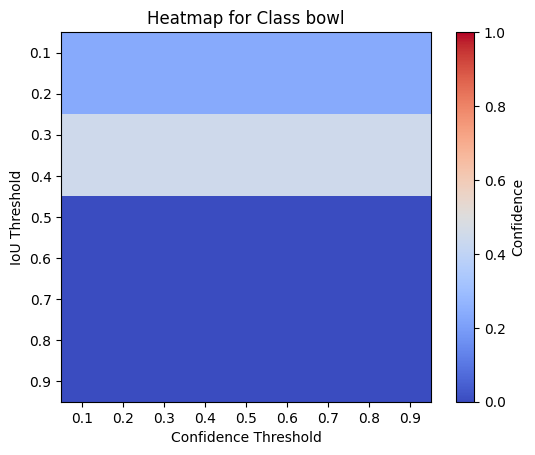

45, bowl


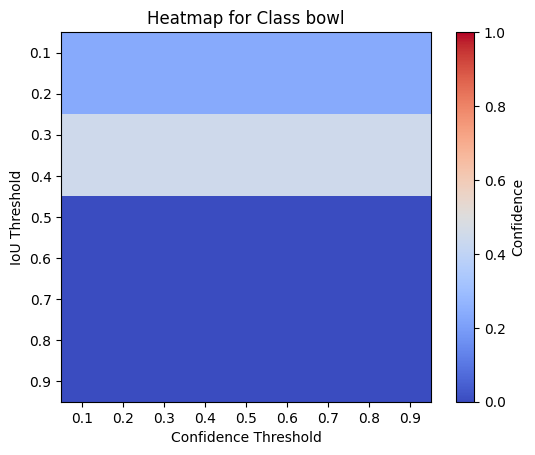

45, bowl


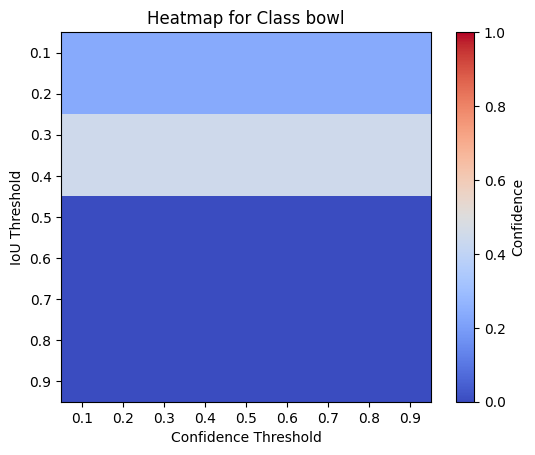

44, spoon


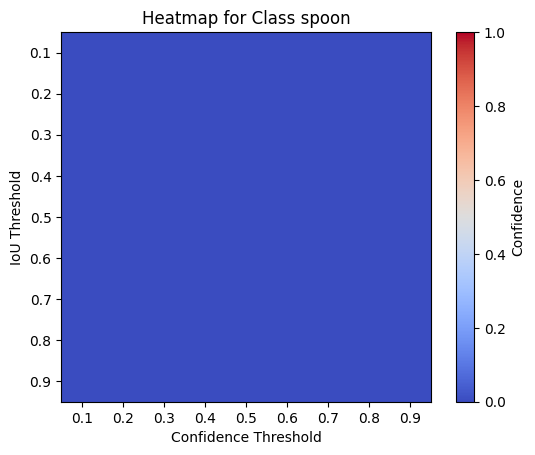

60, diningtable


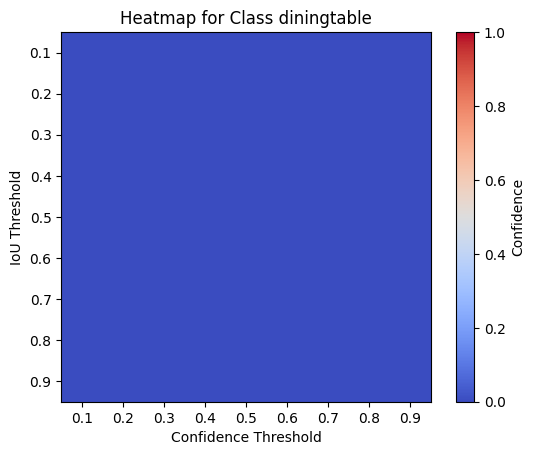

45, bowl


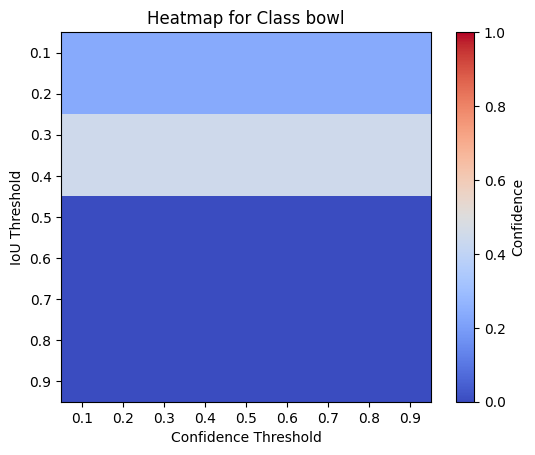

44, spoon


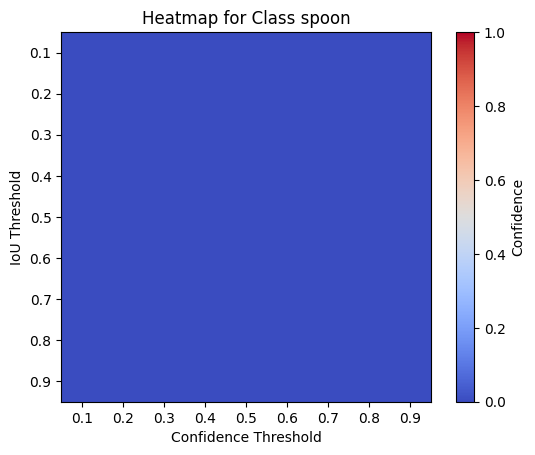

45, bowl


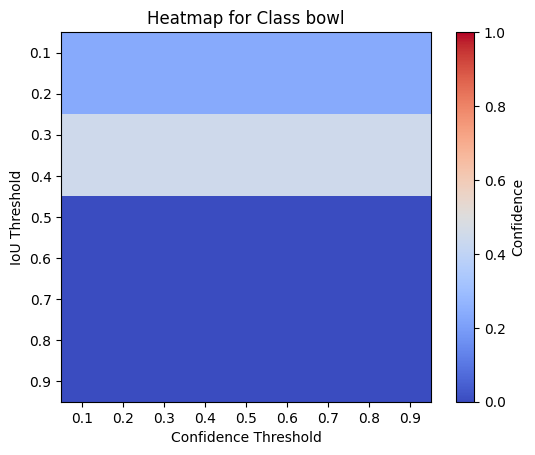

44, spoon


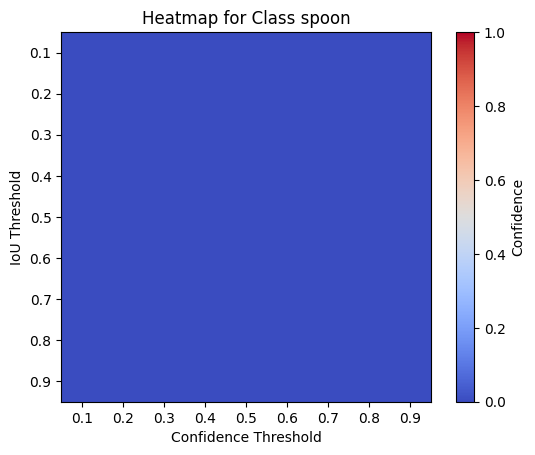

44, spoon


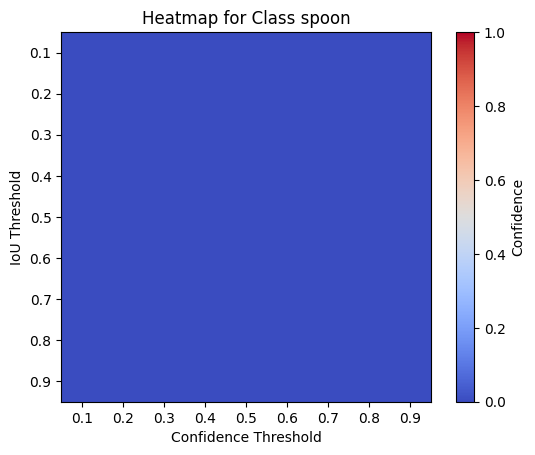

45, bowl


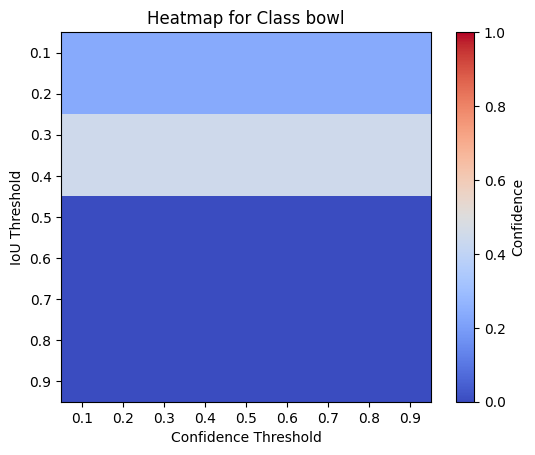

In [59]:
# food.jpg
draw_detection_and_generate_plots('images/food.jpg')

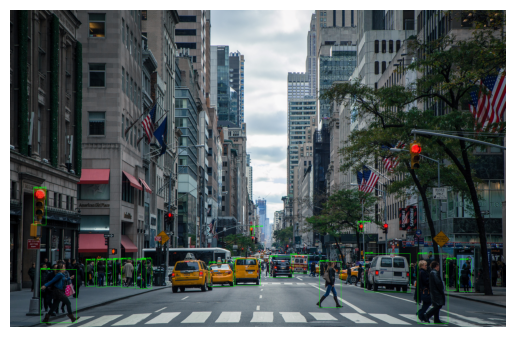

0, person


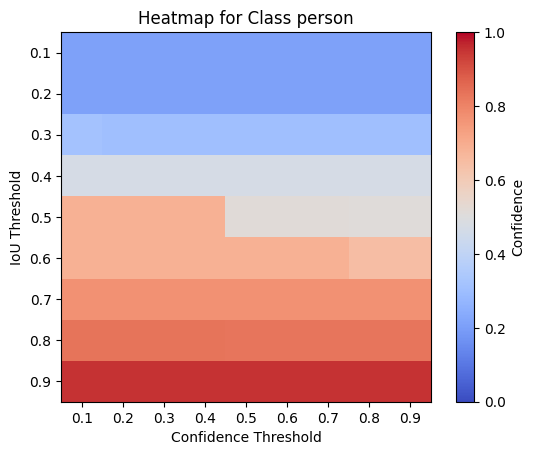

0, person


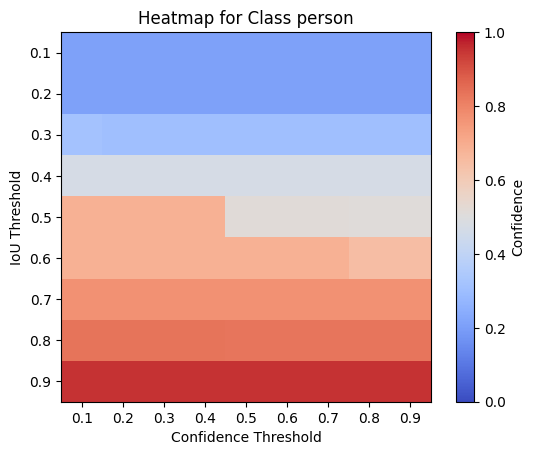

0, person


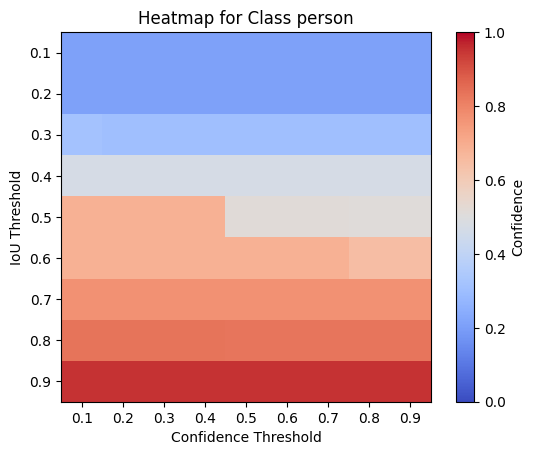

0, person


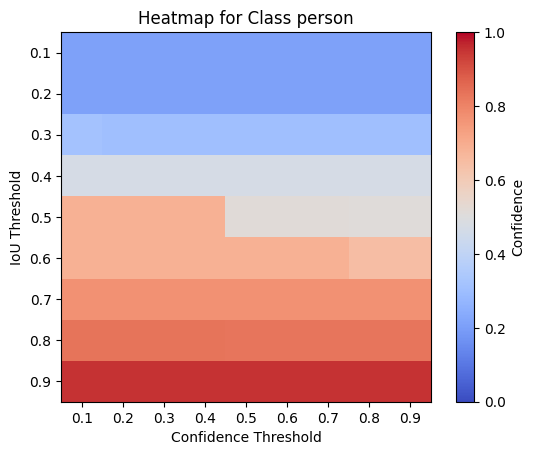

2, car


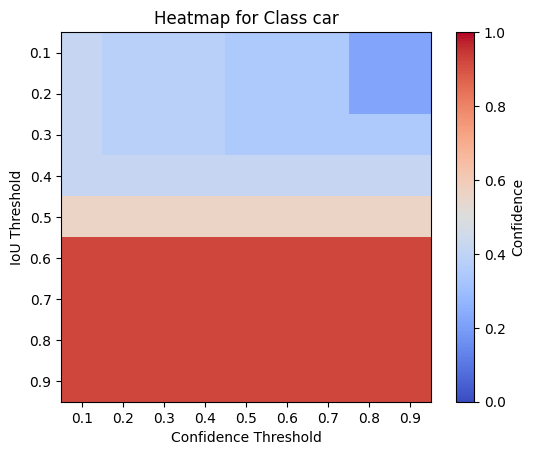

7, truck


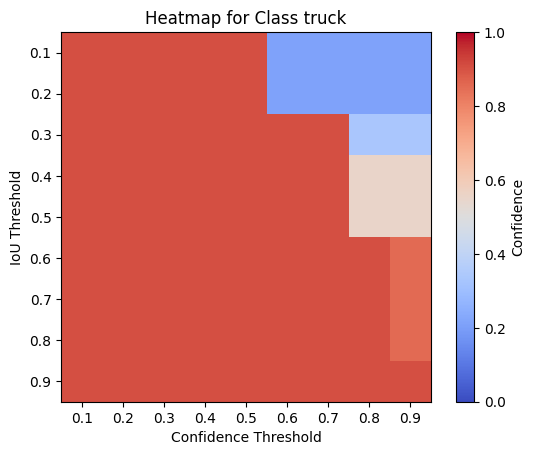

0, person


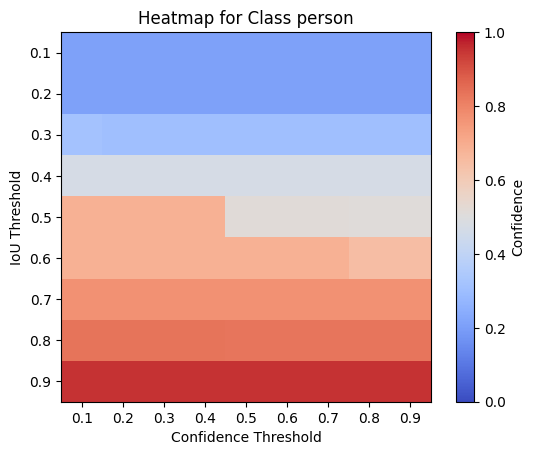

0, person


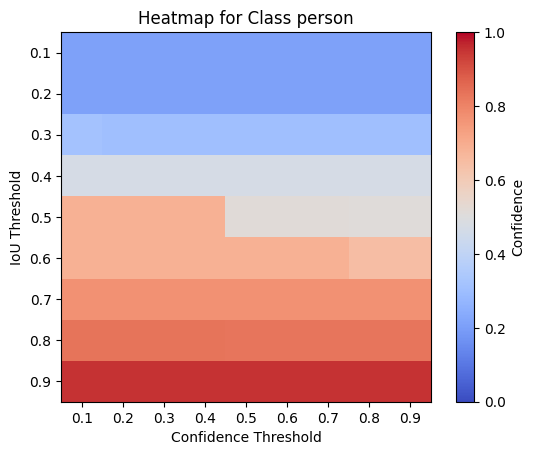

0, person


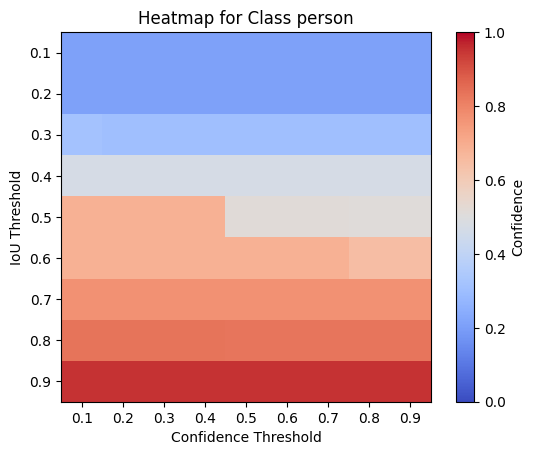

0, person


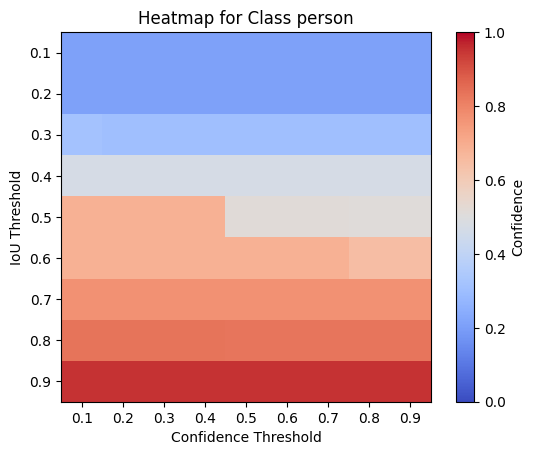

9, traffic light


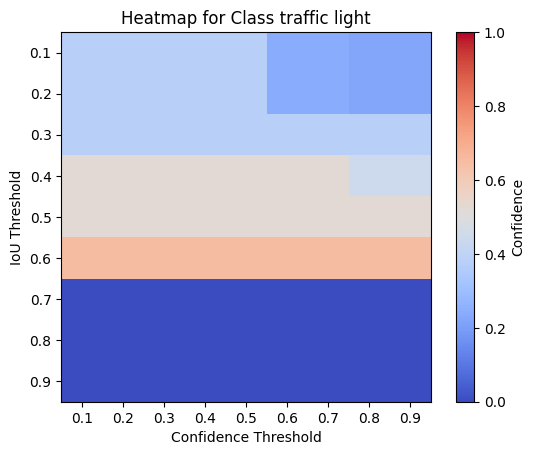

0, person


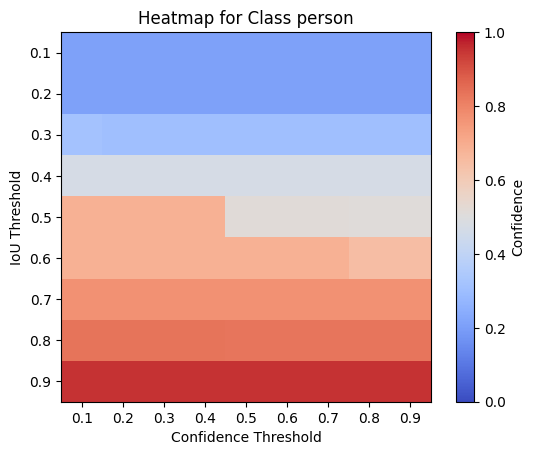

0, person


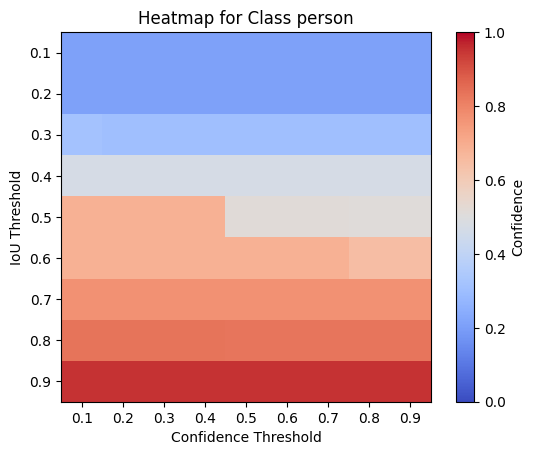

0, person


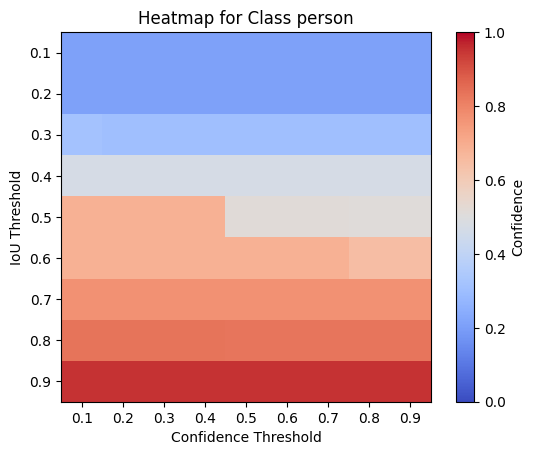

9, traffic light


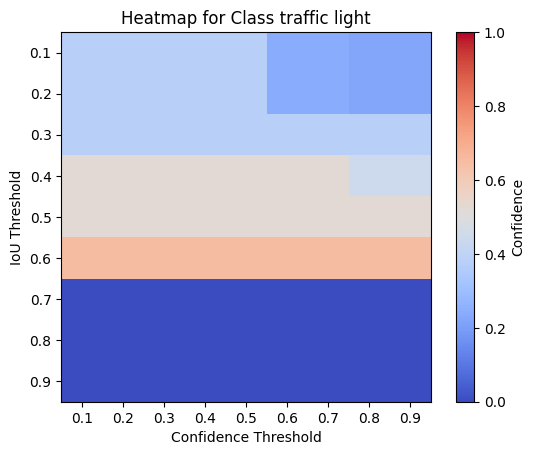

0, person


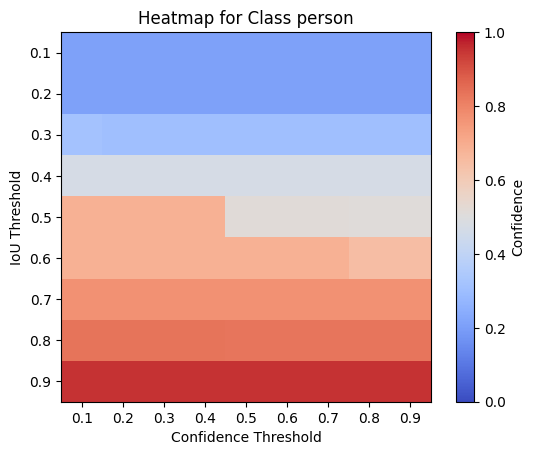

2, car


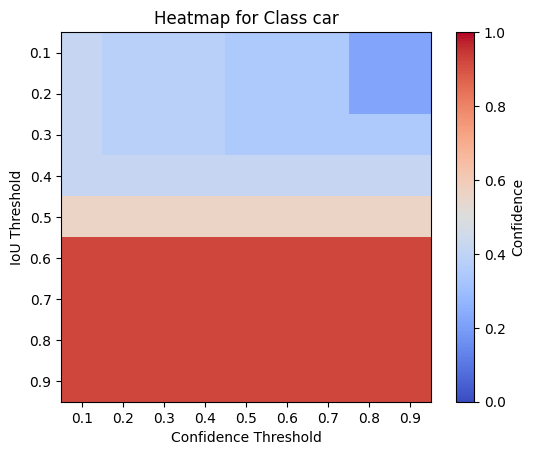

9, traffic light


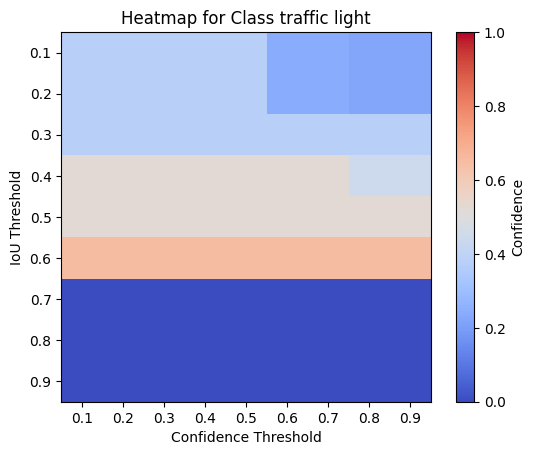

7, truck


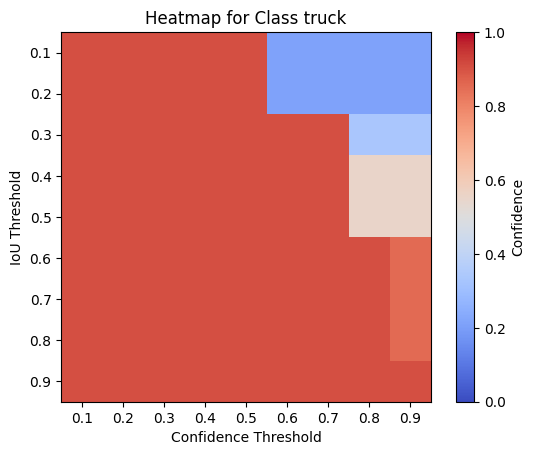

5, bus


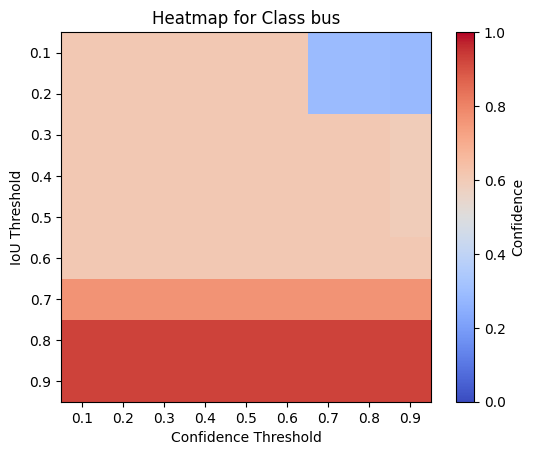

In [60]:
# city_scene.jpg
draw_detection_and_generate_plots('images/city_scene.jpg')

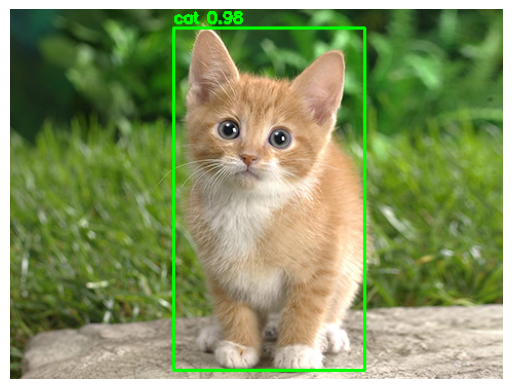

15, cat


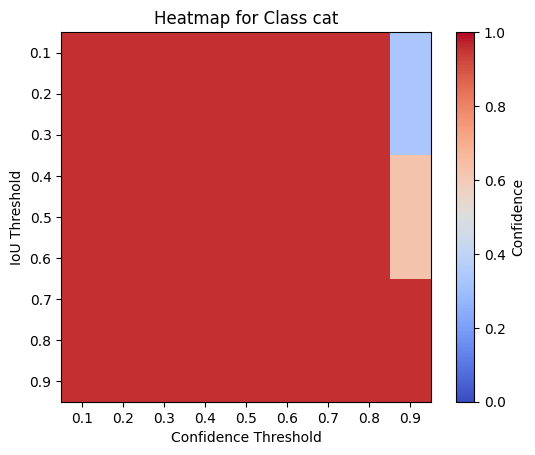

In [61]:
# cat.jpg
draw_detection_and_generate_plots('images/cat.jpg')

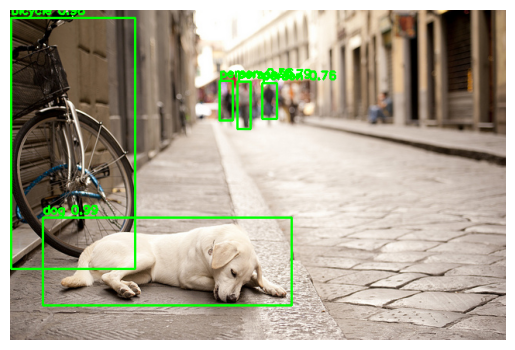

16, dog


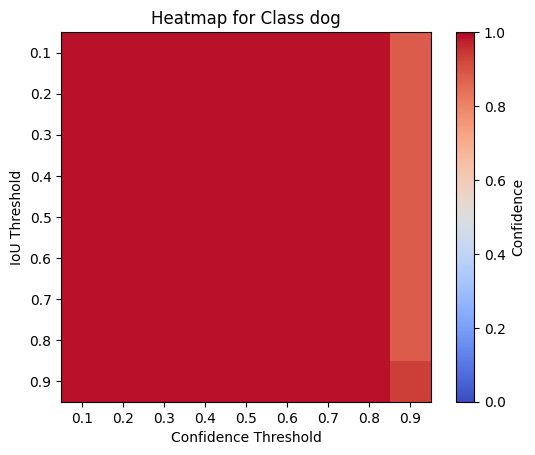

1, bicycle


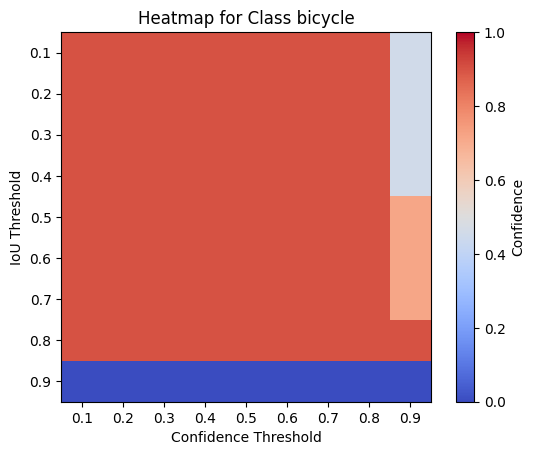

0, person


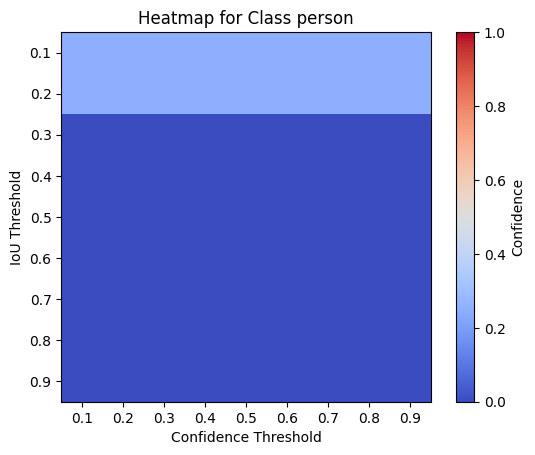

0, person


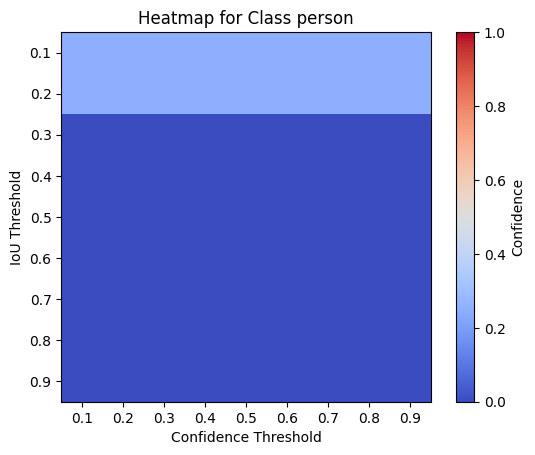

0, person


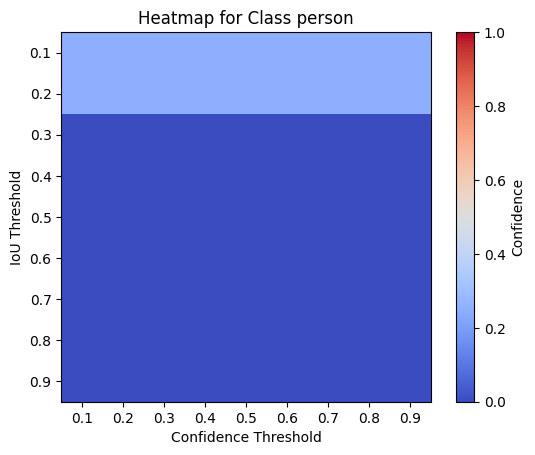

In [62]:
# dog2.jpg
draw_detection_and_generate_plots('images/dog2.jpg')

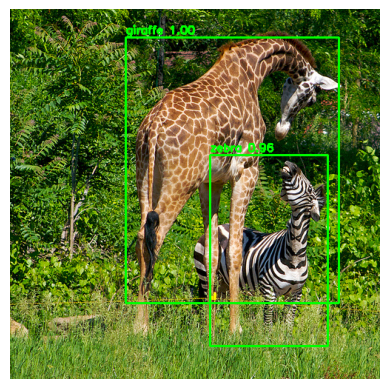

23, giraffe


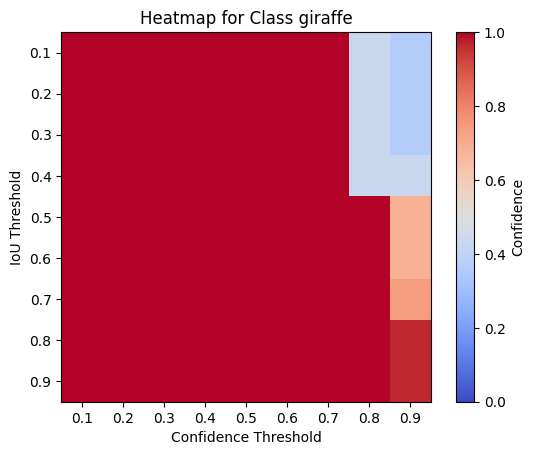

22, zebra


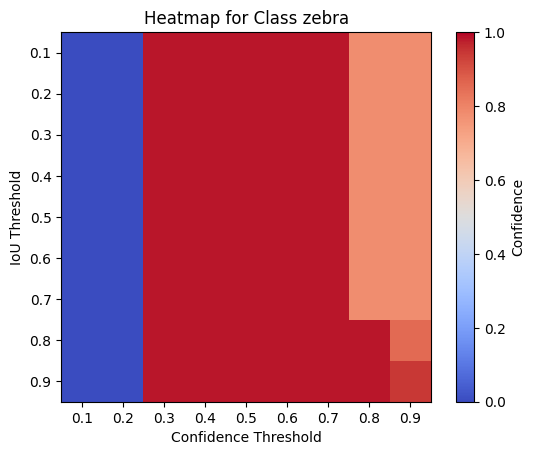

In [63]:
# giraffe.jpg
draw_detection_and_generate_plots('images/giraffe.jpg')

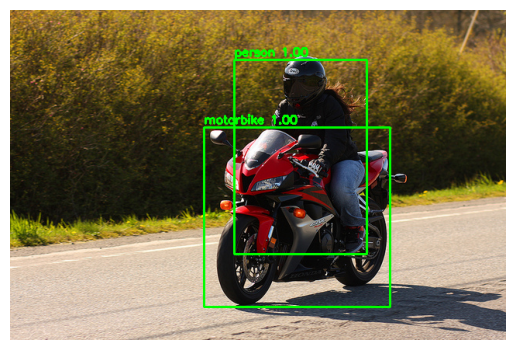

3, motorbike


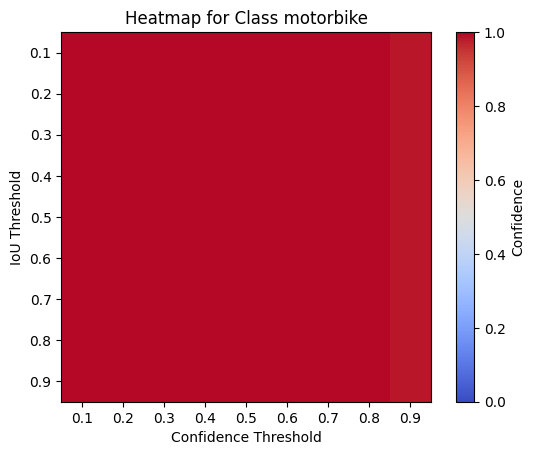

0, person


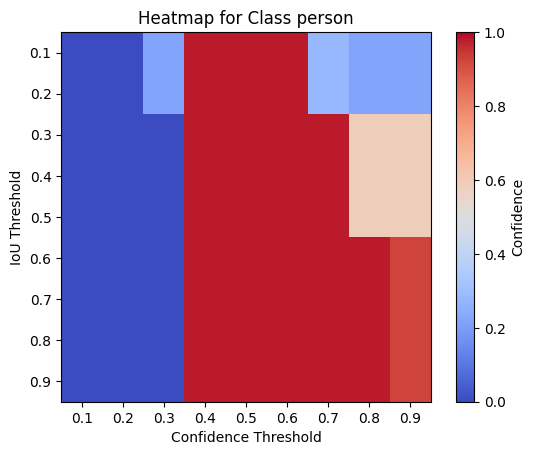

In [64]:
# motorbike.jpg
draw_detection_and_generate_plots('images/motorbike.jpg')

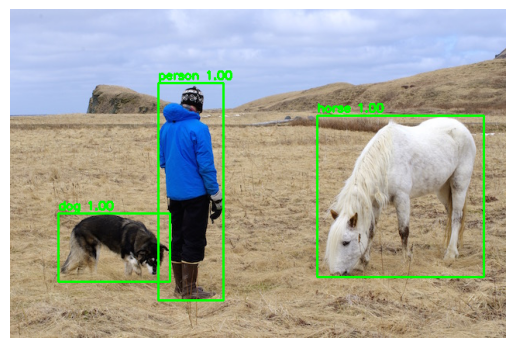

0, person


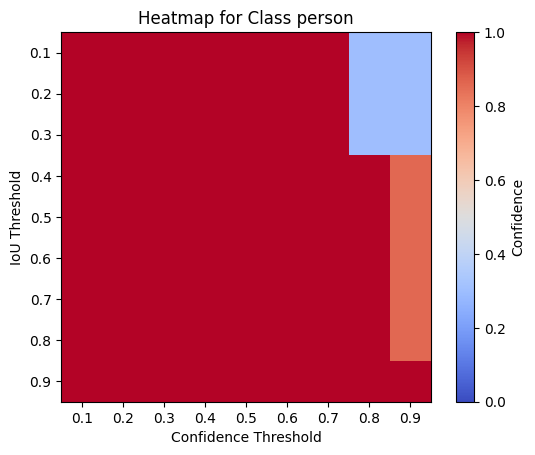

16, dog


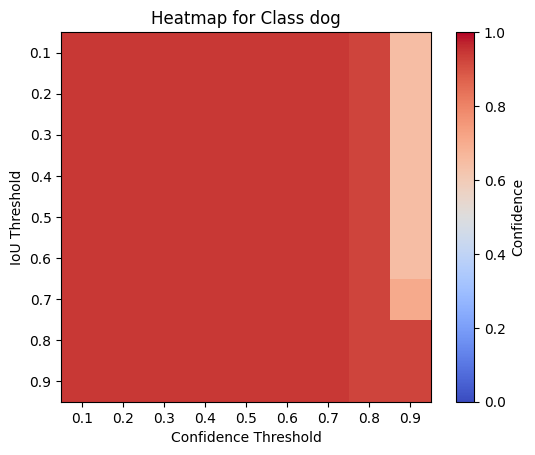

17, horse


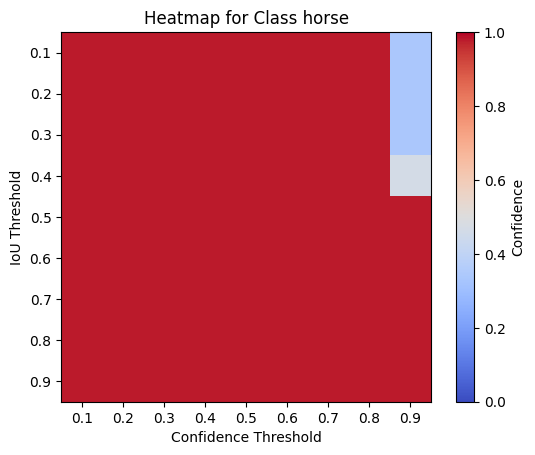

In [65]:
# person.jpg
draw_detection_and_generate_plots('images/person.jpg')

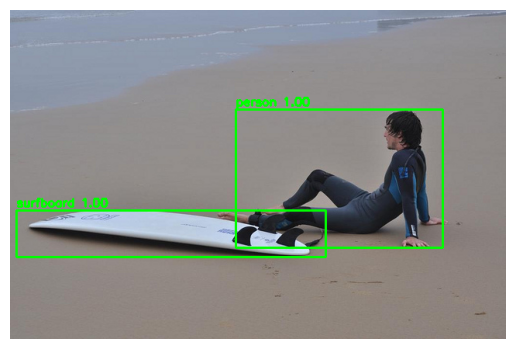

0, person


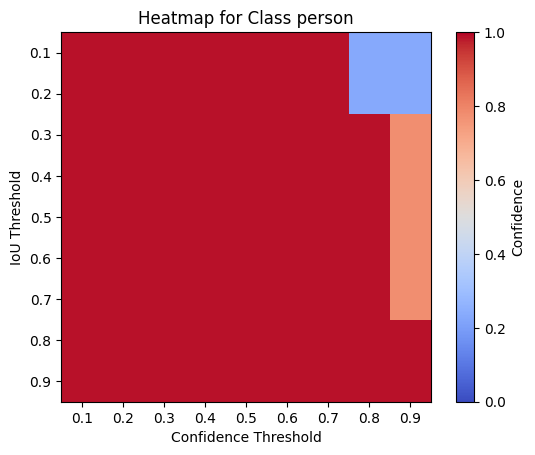

37, surfboard


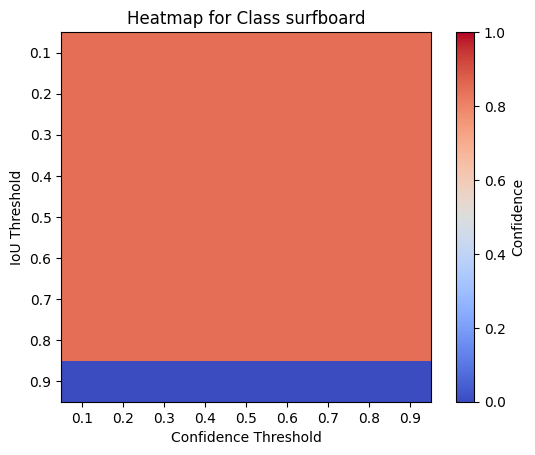

In [66]:
# surf.jpg
draw_detection_and_generate_plots('images/surf.jpg')

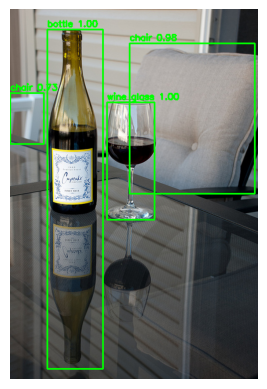

40, wine glass


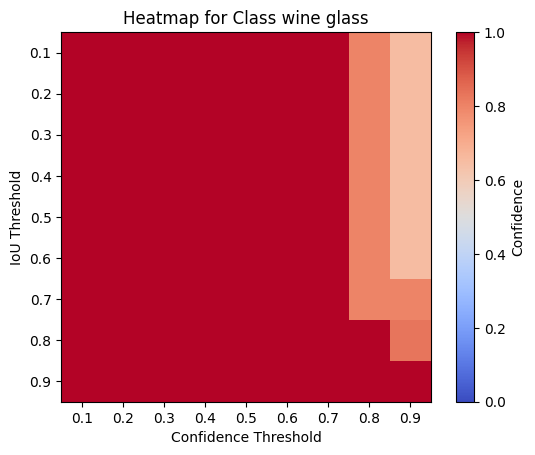

39, bottle


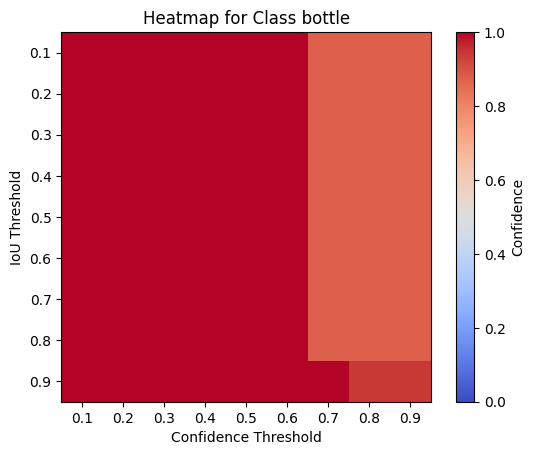

56, chair


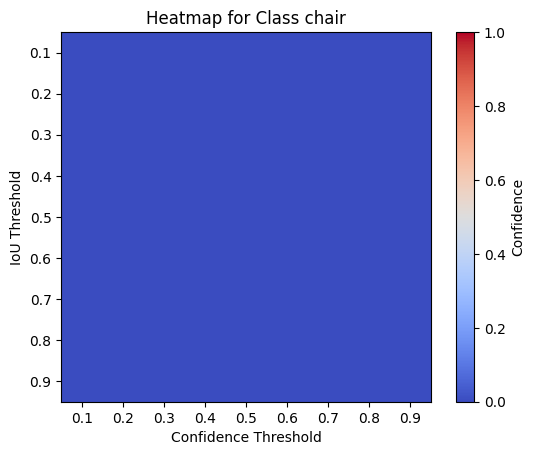

56, chair


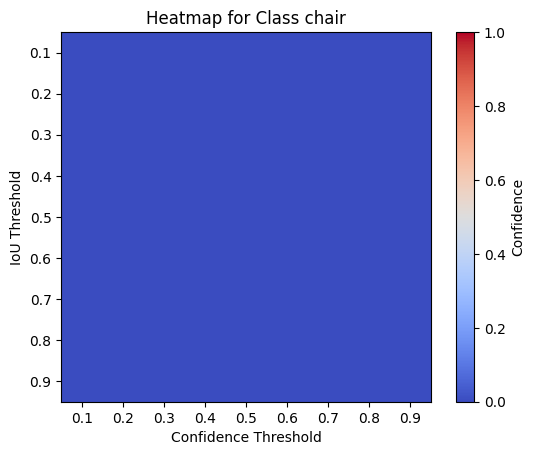

In [67]:
# wine.jpg
draw_detection_and_generate_plots('images/wine.jpg')

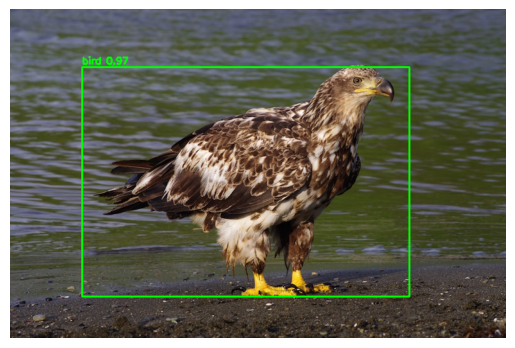

14, bird


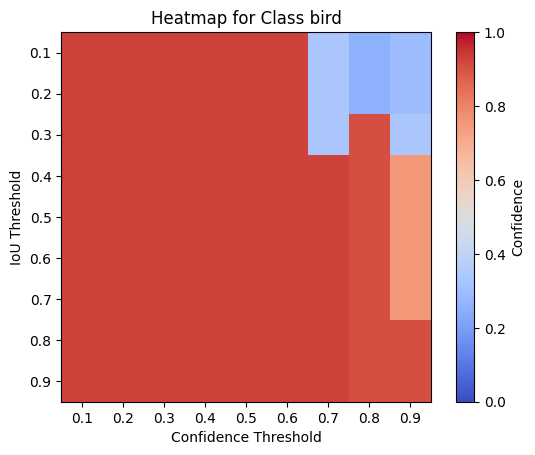

In [68]:
# eagle.jpg
draw_detection_and_generate_plots('images/eagle.jpg')